## 実験目標
- phashを元に抽出した画像の中にある外れ値(特徴的な画像)を取り出す。

- 教師なし学習による特徴的な画像の抽出
    - 非階層的クラスタリングによる外れ値抽出
    - 階層的クラスタリングによる外れ値抽出
    - DeepClusterによる外れ値抽出

## 実験手順
- 画像の読み込み
- 非階層的クラスタリングによる外れ値検出
    - HML分析のHだけを取り出してみる
    - Hを除いて繰り返しクラスタリングさせることでどういう外れ値が取れるのか見てみる

## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.core.pylabtools import figsize

import os
import sys

## 画像の読み込み

In [2]:
dir_path = "/media/nvidia/JetsonTX2SSD240/data/sup_or_inf_20181114/plus_minus_0/"
using_img_name = "original/"

size_rate = 4

In [3]:
# スケルトン画像についてクラスタリングしてみる
orig_imgs = []
img_orig_names = []

for root, dirs, files in os.walk(os.path.join(dir_path, using_img_name)):
    for file in tqdm(sorted(files)):
        img = cv2.imread(root + file, 0)
        height, width = img.shape
        img = cv2.resize(img, (int(width/size_rate), int(height/size_rate)))
        orig_imgs.append(img)
        img_orig_names.append(file)
    max_imgs = len(files)

In [4]:
using_img_name = "skelton/"

In [5]:
# スケルトン画像についてクラスタリングしてみる
skel_imgs = []
img_skel_names = []

for root, dirs, files in os.walk(os.path.join(dir_path, using_img_name)):
    for file in tqdm(sorted(files)):
        img = cv2.imread(root + file, 0)

#         if img.mean() == 255:
#             continue
        height, width = img.shape
        img = cv2.resize(img, (int(width/size_rate), int(height/size_rate)))
        skel_imgs.append(img)
        img_skel_names.append(file)
    max_imgs = len(files)

In [6]:
np.array(orig_imgs).shape

(1247, 72, 130)

In [7]:
np.array(skel_imgs).shape

(1247, 72, 130)

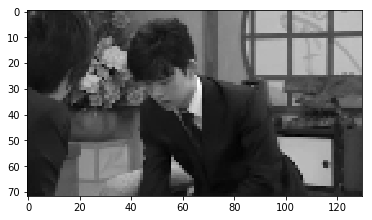

In [8]:
plt.imshow(orig_imgs[0], cmap="gray", vmin = 0, vmax = 255)

In [9]:
img_orig_names[0]

'pose_orig_handnum10_frame301_AbemaTV_Tournament_Final2.png'

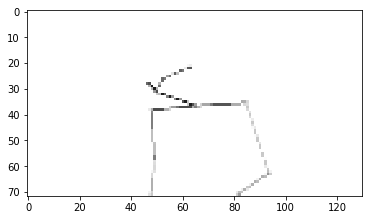

In [10]:
plt.imshow(skel_imgs[0], cmap="gray", vmin = 0, vmax = 255)

In [11]:
img_skel_names[0]

'pose_skel_handnum10_frame301_AbemaTV_Tournament_Final2.png'

おそらくスケルトンが取れていない可能性が高いため、phash差である30以上の画像はこれが近いものと考えられる。

In [12]:
skel_imgs[198].mean()

252.77980769230768

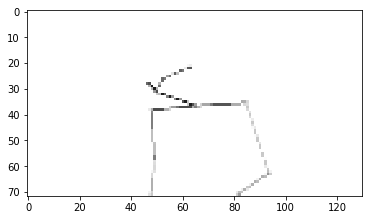

In [13]:
plt.imshow(skel_imgs[0], cmap="gray", vmin = 0, vmax = 255)

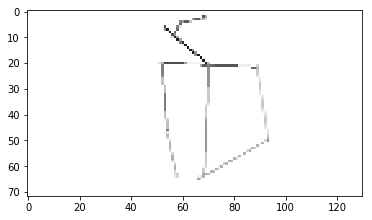

In [14]:
plt.imshow(skel_imgs[198], cmap="gray", vmin = 0, vmax = 255)

## Kmeansでクラスタリング(クラスタ数はシルエット分析で評価)

In [15]:
use_category_imgs = skel_imgs

In [16]:
img_df = pd.DataFrame(np.array([img.reshape(1, -1) for img in use_category_imgs]).reshape(max_imgs, -1))

In [17]:
def select_n_cluster(X):
    n_clusters = 2
    silhouette_max = 0
    early_thresh = 4
    max_cluster = 50
 
    sse = []
    with tqdm(total=max_cluster) as pbar:
        while n_clusters < max_cluster:
            clusterer = KMeans(init='k-means++', n_clusters=n_clusters, random_state=0)
            cluster_labels = clusterer.fit_predict(X)
            kmeans = clusterer.fit(X)

            # SSE（クラスター内誤差の平方和）
            sse.append(kmeans.inertia_) 

            # シルエット値（-1～1）の平均
            silhouette_avg = silhouette_score(X, cluster_labels)

            print('For n_clusters =', n_clusters,
                  'The average silhouette_score is :', silhouette_avg)

            if silhouette_max < silhouette_avg:
                silhouette_max = silhouette_avg
                silhouette_max_id = n_clusters
            else:
                if (n_clusters - silhouette_max_id) > early_thresh:
                    break
                    
            n_clusters += 1
            pbar.update(1)
                    
        
    # エルボー図のプロット
    plt.plot([_ for _ in range(2, n_clusters+1)], sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()
    
    return silhouette_max_id

In [18]:
img_df.shape

(1247, 9360)

In [19]:
orig_imgs[0].shape

(72, 130)

In [20]:
72 * 130

9360

For n_clusters = 2 The average silhouette_score is : 0.017713719240930473
For n_clusters = 3 The average silhouette_score is : 0.012131817567515366
For n_clusters = 4 The average silhouette_score is : 0.01982444451857799
For n_clusters = 5 The average silhouette_score is : 0.02806630585068224
For n_clusters = 6 The average silhouette_score is : 0.03363363590956325
For n_clusters = 7 The average silhouette_score is : 0.02506889916002646
For n_clusters = 8 The average silhouette_score is : 0.029384209734500778
For n_clusters = 9 The average silhouette_score is : 0.03692846075045734
For n_clusters = 10 The average silhouette_score is : 0.03578206050452832
For n_clusters = 11 The average silhouette_score is : 0.03598474598197458
For n_clusters = 12 The average silhouette_score is : 0.04118761725808405
For n_clusters = 13 The average silhouette_score is : 0.04204940817027742
For n_clusters = 14 The average silhouette_score is : 0.038707992118599786
For n_clusters = 15 The average silhouette

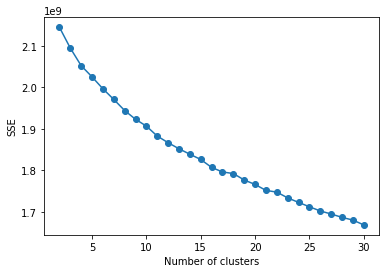

In [21]:
silhouette_max_id = select_n_cluster(img_df)

現状シルエット分析による最適クラスタ数は6であることがわかったので、6でクラスタリングする。

### Kmeansで初回クラスタリング

In [22]:
cls = KMeans(n_clusters=silhouette_max_id, random_state=98).fit(img_df)

In [23]:
labels = cls.labels_

In [24]:
img_df["cluster_id"] = labels

In [25]:
img_df["cluster_id"].value_counts()

8     150
20    121
13     92
12     70
3      70
16     67
19     66
9      53
10     50
2      50
18     50
21     47
0      43
22     40
7      38
15     37
14     35
4      32
6      30
5      24
23     21
17     18
1      16
24     16
11     11
Name: cluster_id, dtype: int64

### PCAで次元削減し散布図で確認

In [26]:
pca = PCA(n_components=2)
pca_img = pca.fit_transform(img_df.iloc[:, :-1])

In [27]:
pca_df = pd.DataFrame(pca_img)
pca_df["cluster_id"] = cls.labels_

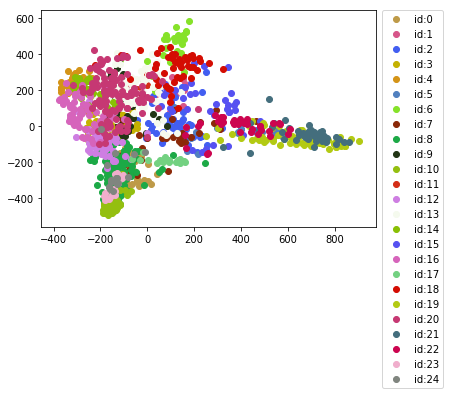

In [28]:
fig, ax = plt.subplots()
#colors = cm.Accent.colors
colors = np.random.rand(silhouette_max_id, 3)
for i in range(silhouette_max_id):
    target = pca_df[pca_df['cluster_id'] == i]
    ax.scatter(x=target[0], y=target[1], c=colors[i])
    ax.legend(["id:{}".format(_) for _ in range(silhouette_max_id)], bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)

In [29]:
def compare_plot(imgs, labels, cmaps=None):
    fig, ax = plt.subplots(1, len(labels), figsize=(6*len(labels),6))

    for i, im in enumerate(imgs):
        if len(im.shape) == 3:
            ax[i].imshow(im)
        else:
            ax[i].imshow(im, cmap=cmaps[i])
        ax[i].set_title(labels[i])
    plt.show()

cluster id: 0, total: 43


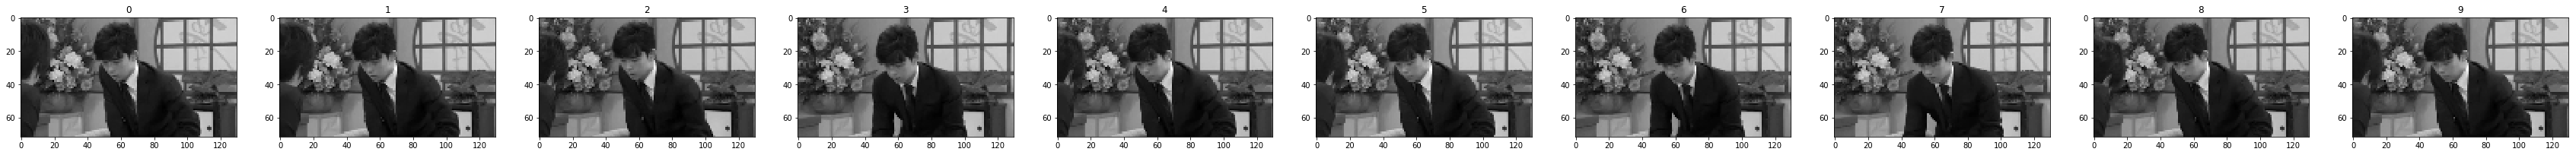

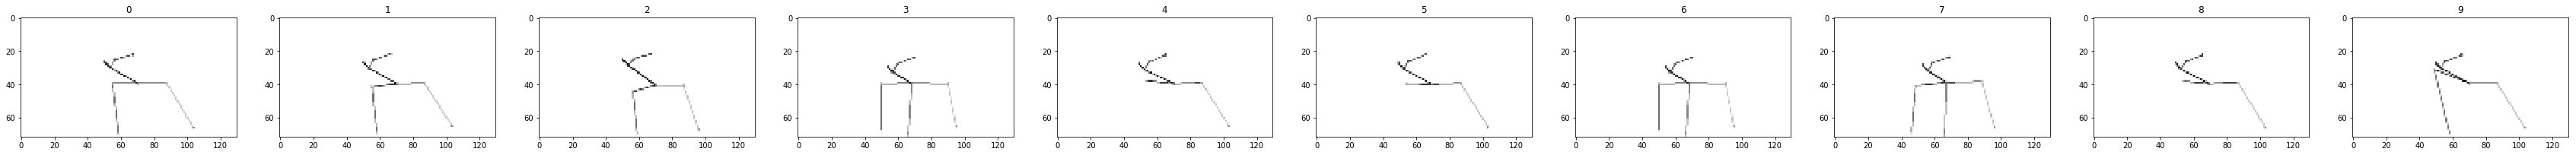

cluster id: 1, total: 16


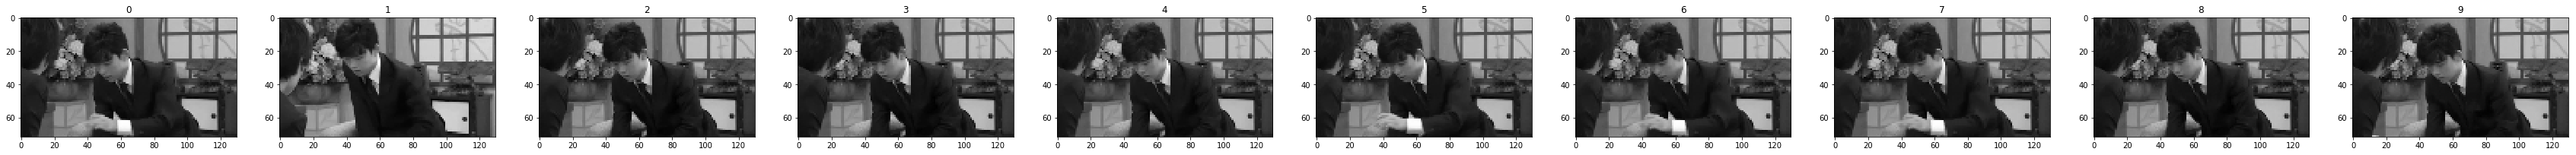

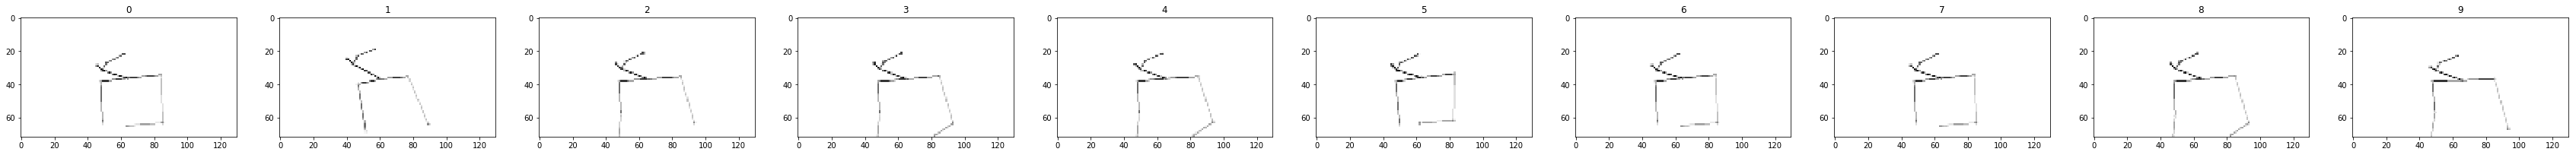

cluster id: 2, total: 50


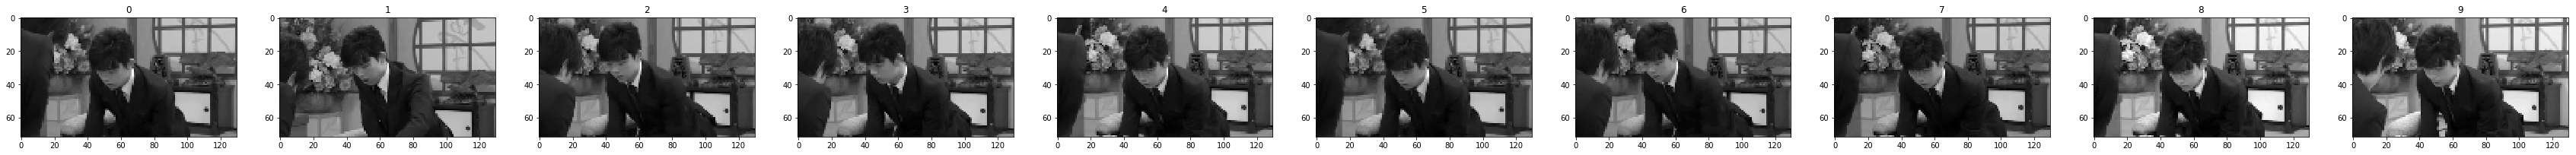

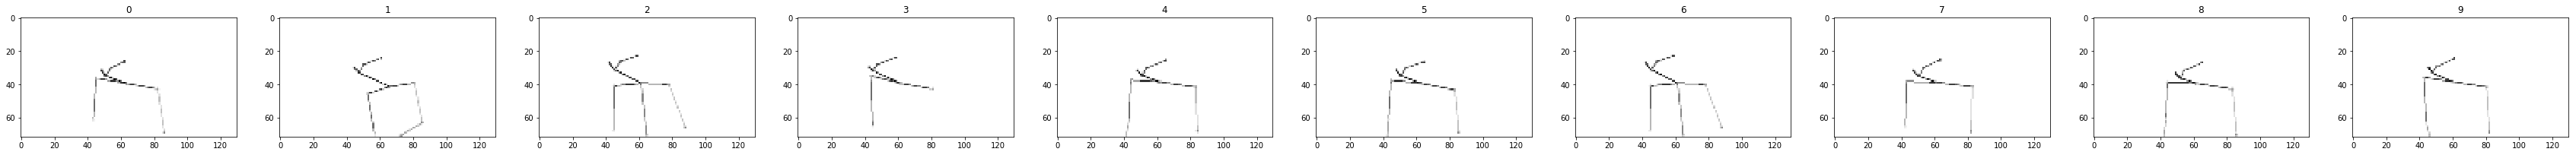

cluster id: 3, total: 70


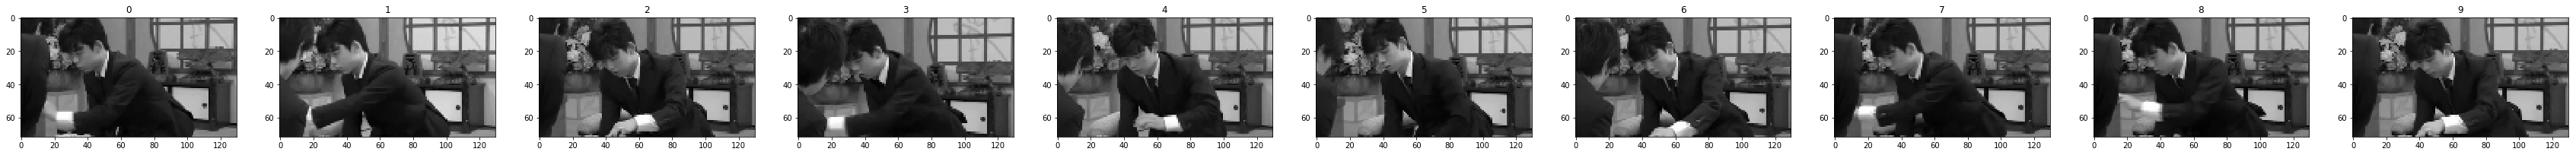

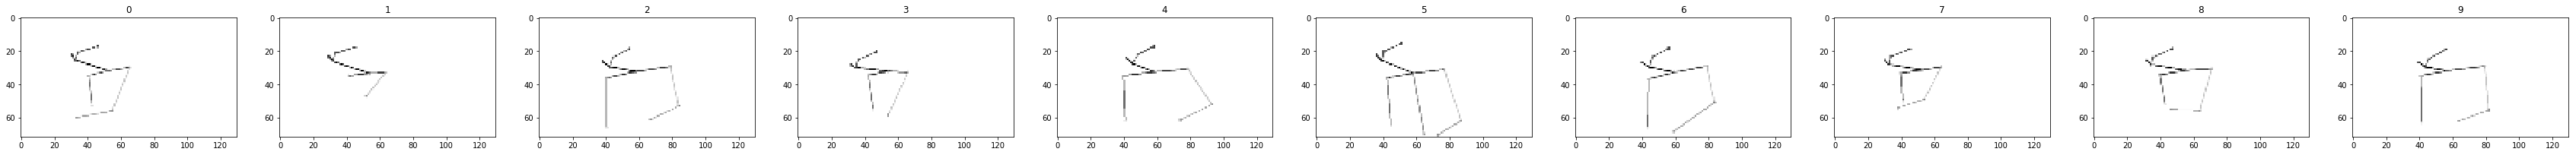

cluster id: 4, total: 32


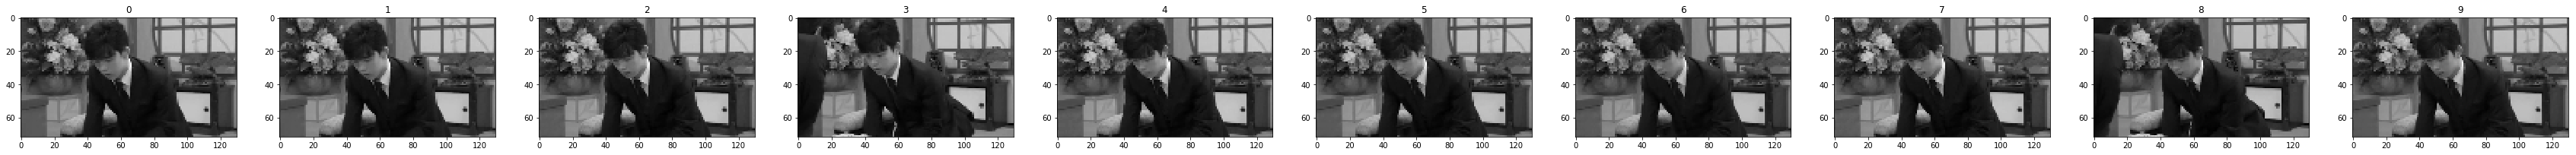

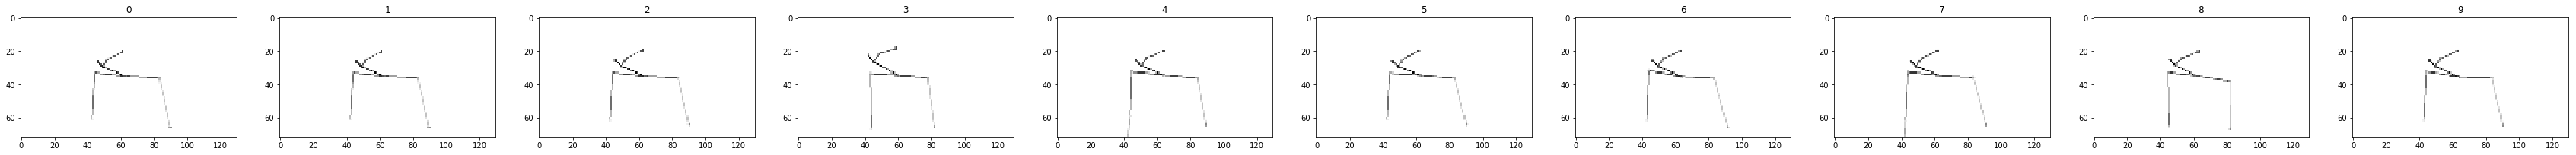

cluster id: 5, total: 24


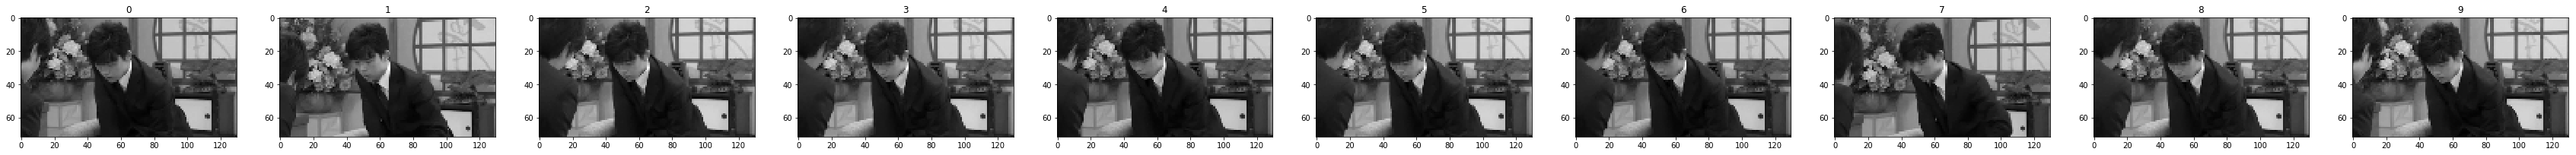

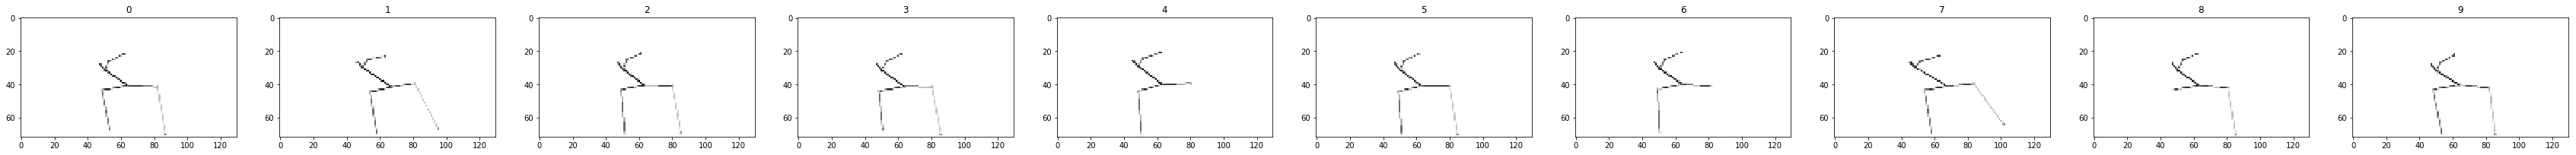

cluster id: 6, total: 30


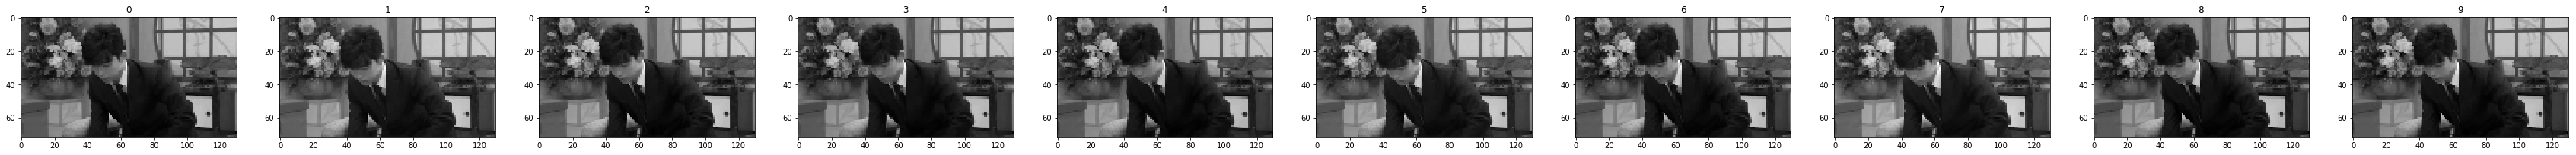

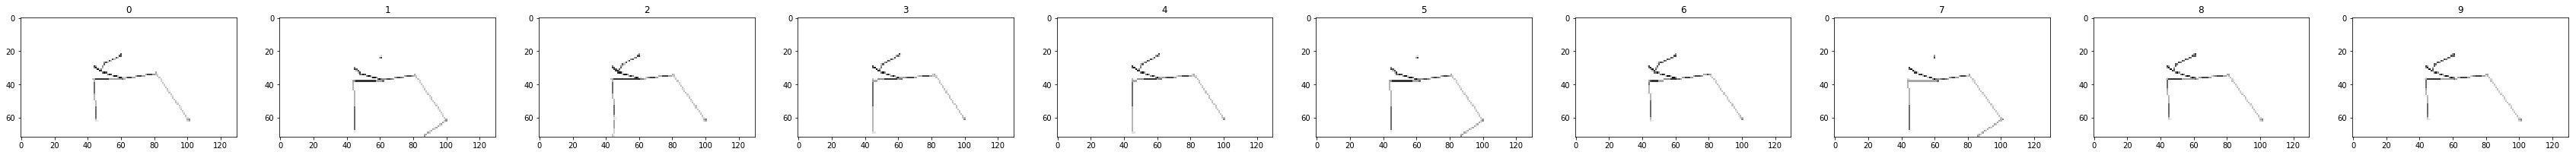

cluster id: 7, total: 38


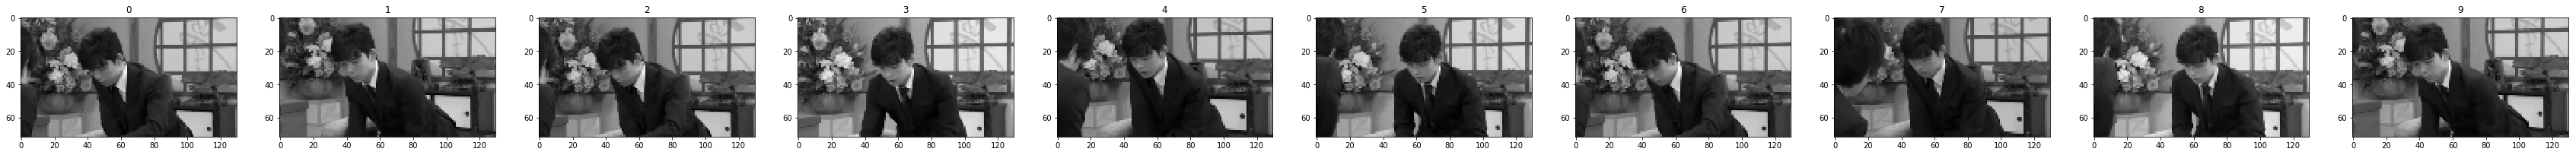

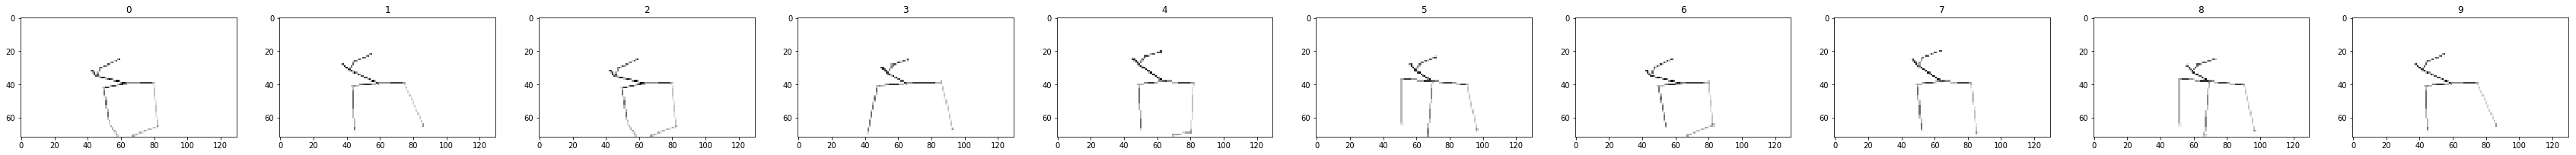

cluster id: 8, total: 150


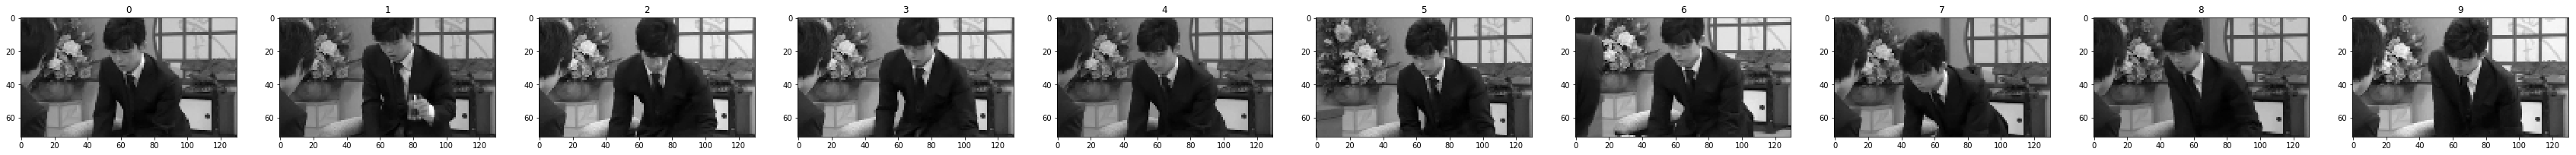

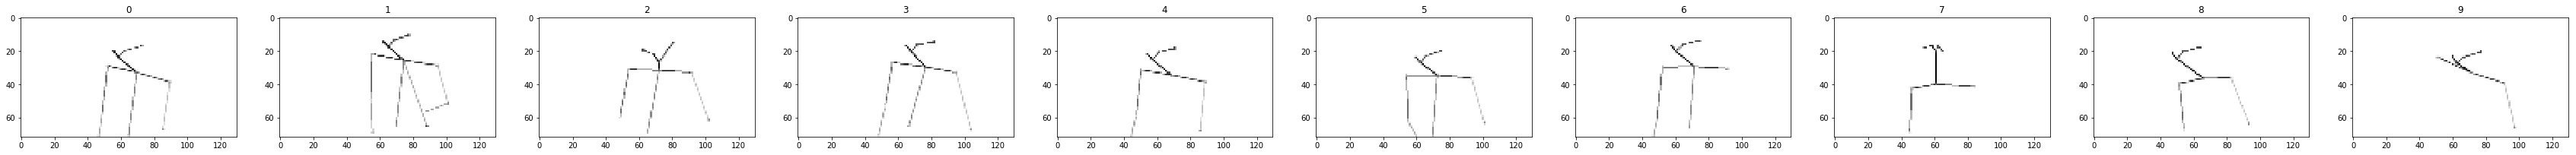

cluster id: 9, total: 53


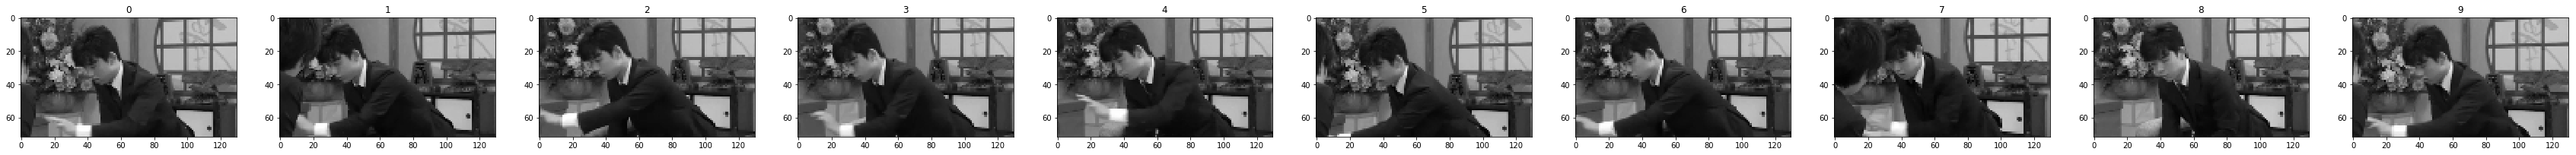

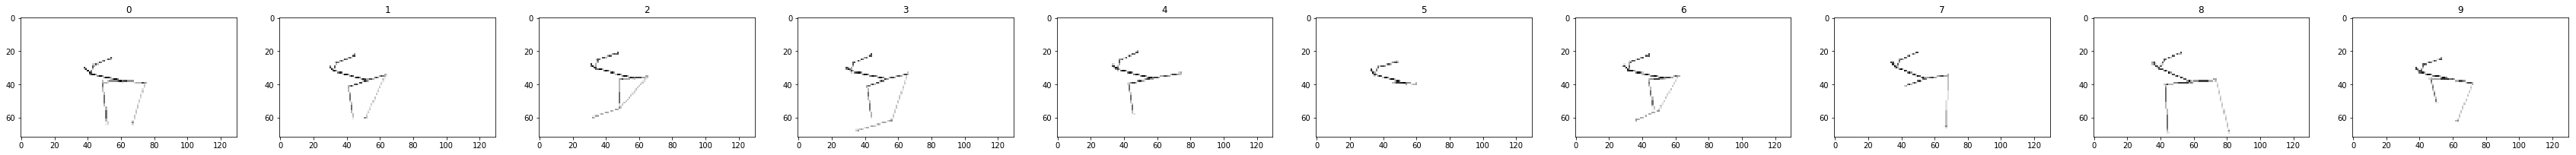

cluster id: 10, total: 50


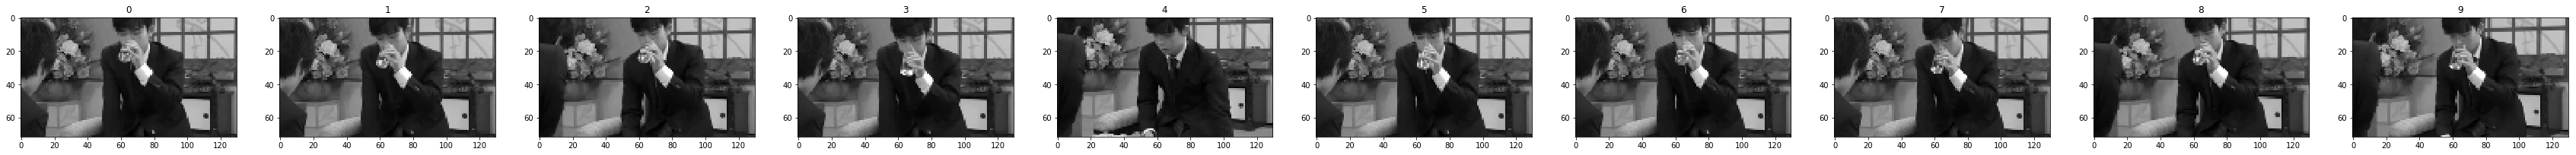

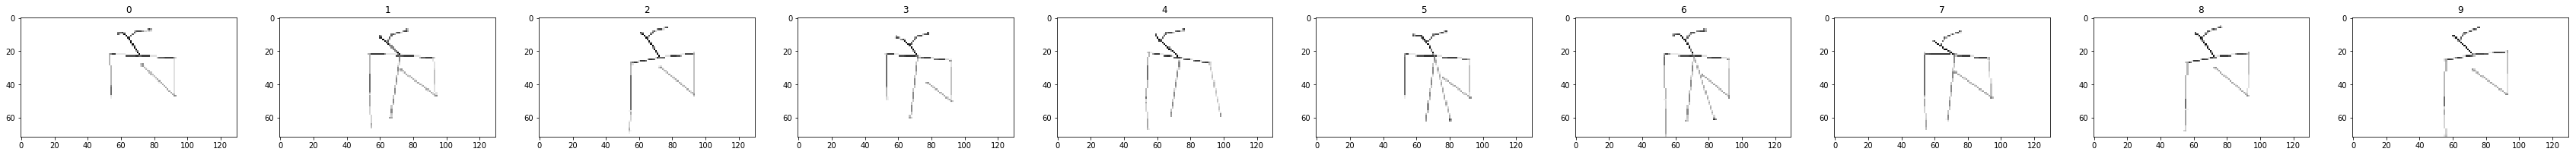

cluster id: 11, total: 11


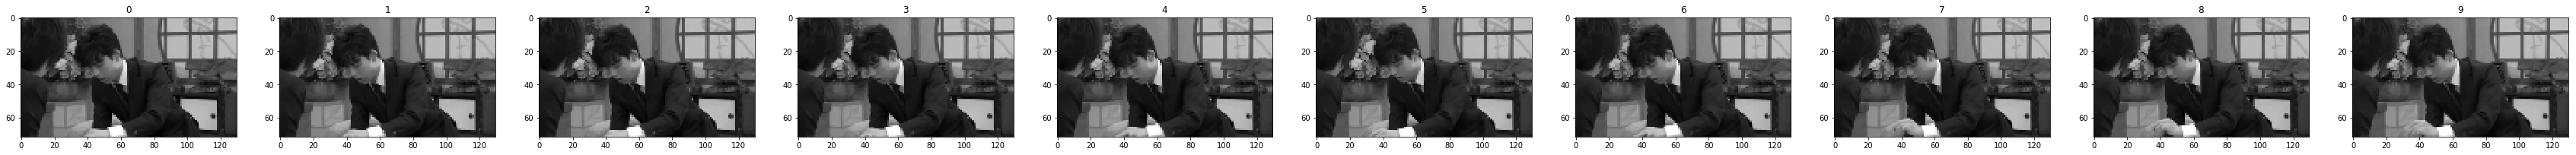

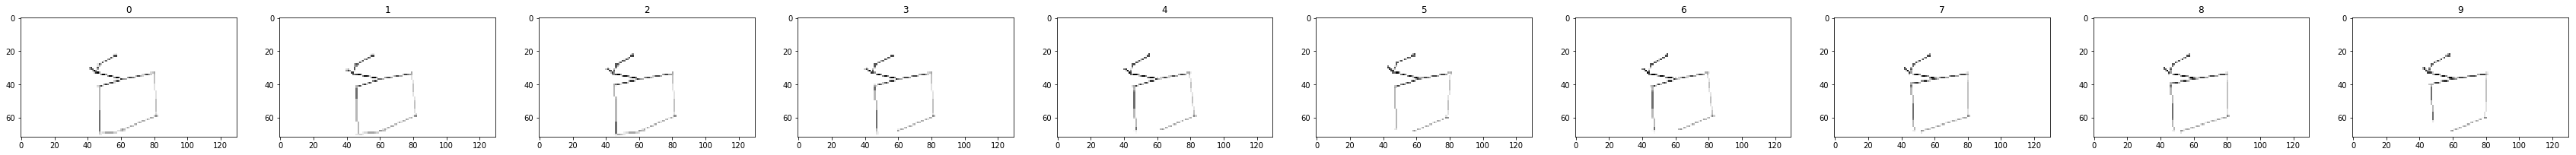

cluster id: 12, total: 70


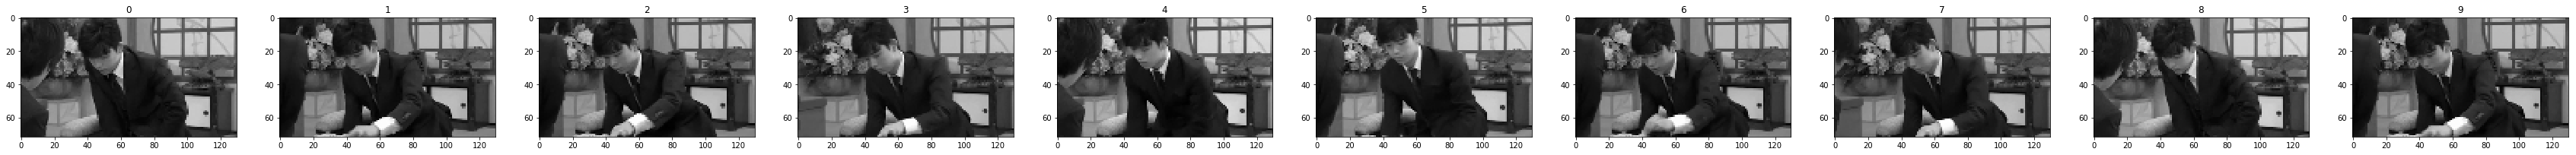

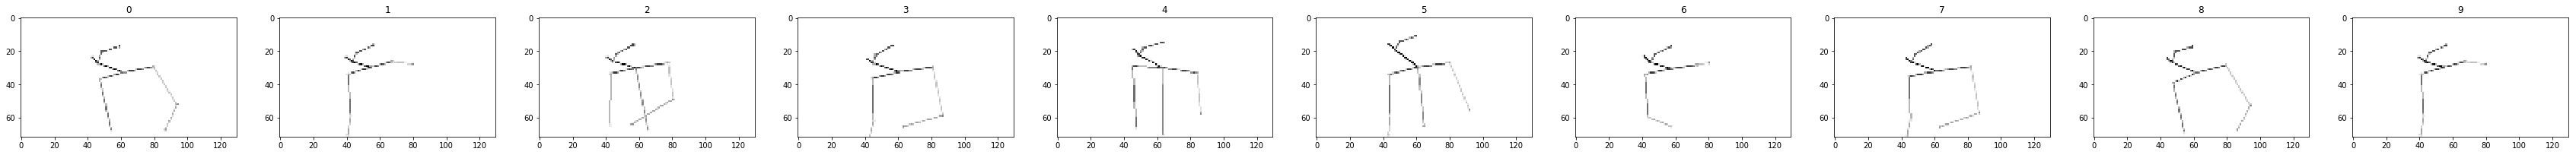

cluster id: 13, total: 92


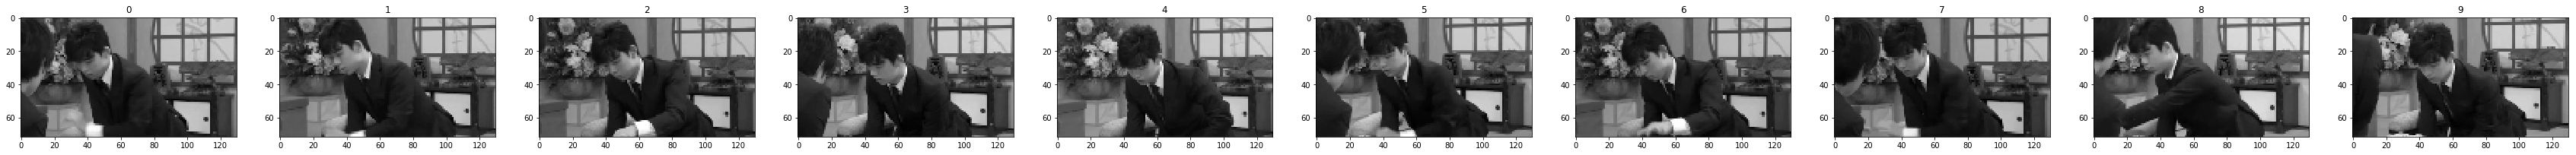

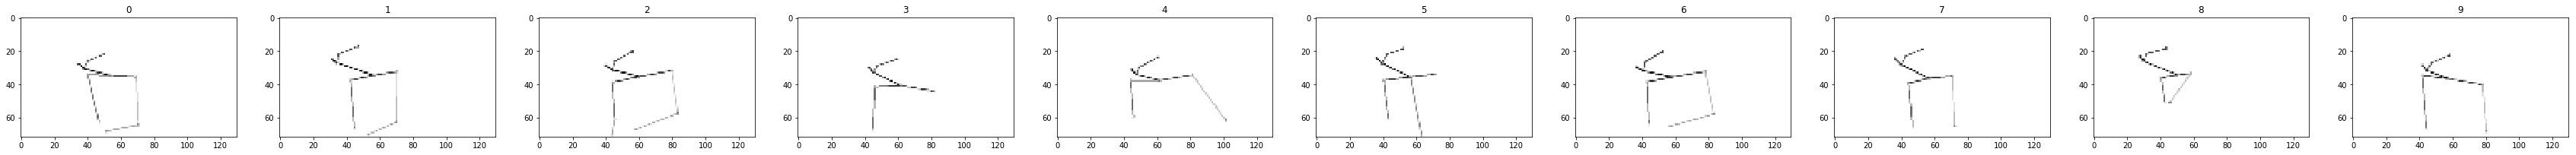

cluster id: 14, total: 35


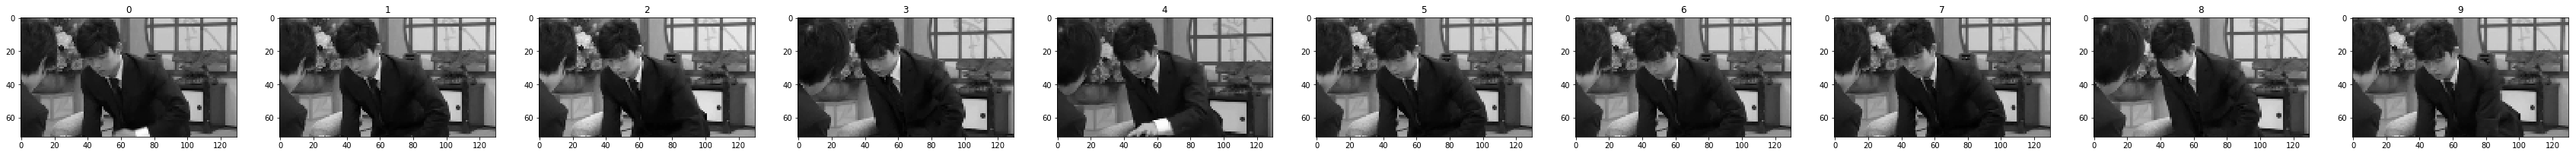

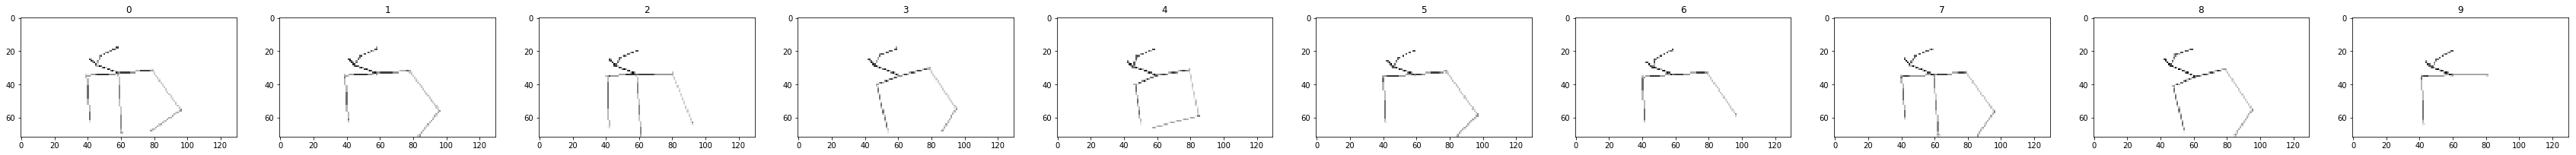

cluster id: 15, total: 37


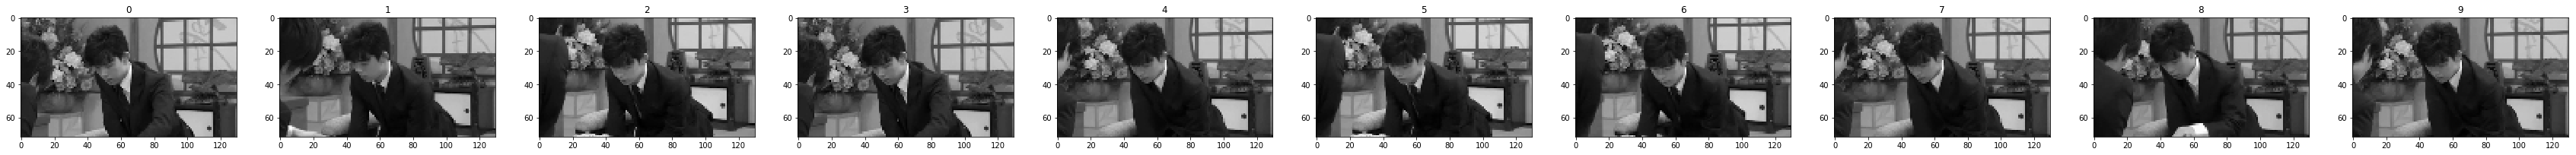

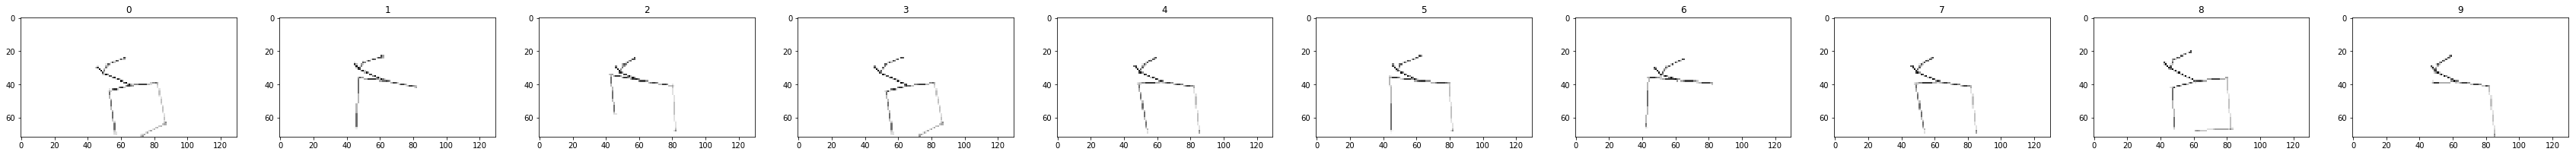

cluster id: 16, total: 67


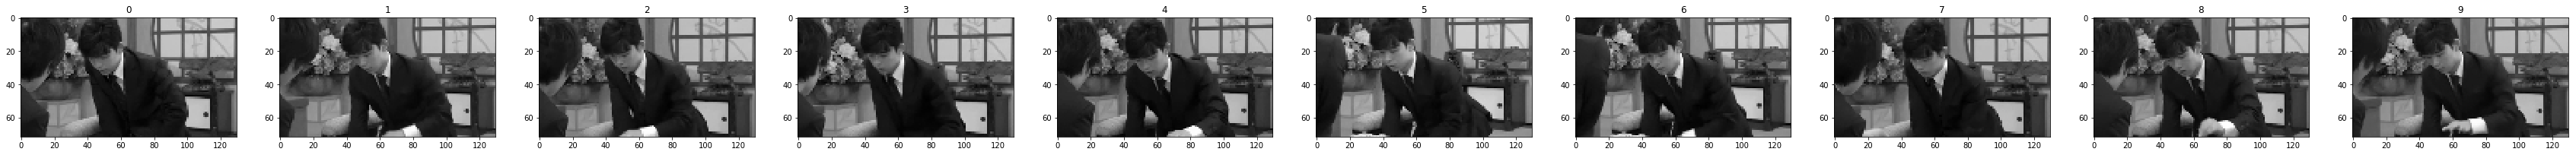

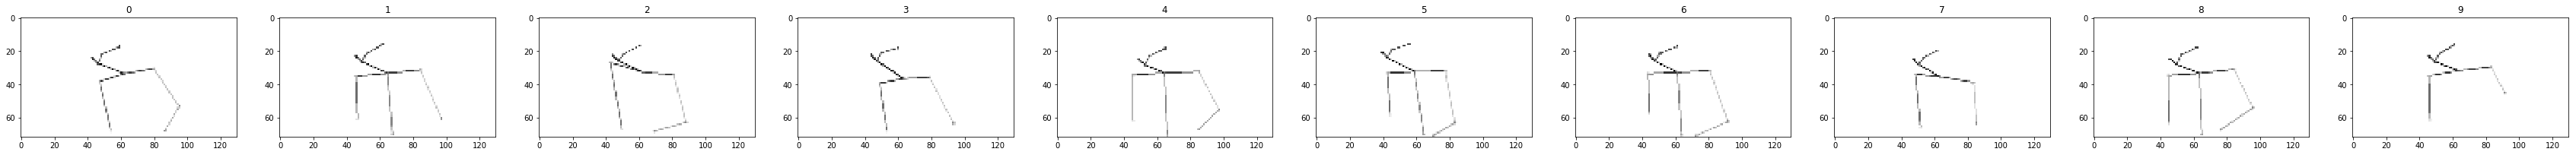

cluster id: 17, total: 18


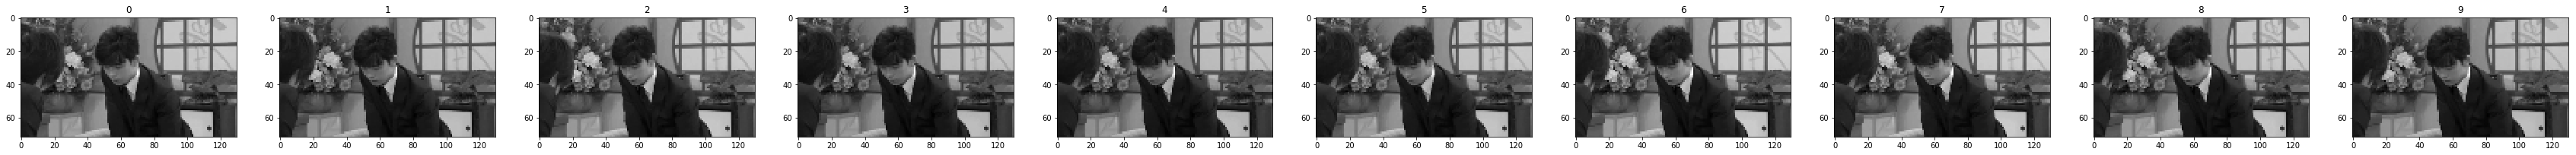

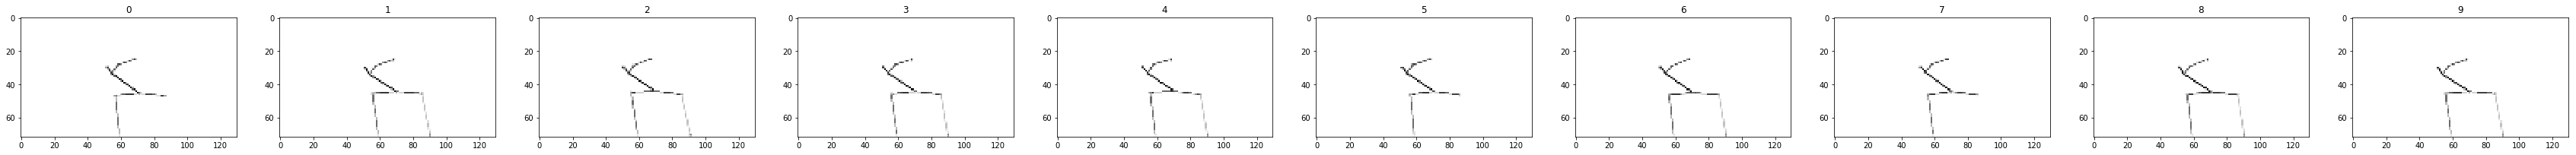

cluster id: 18, total: 50


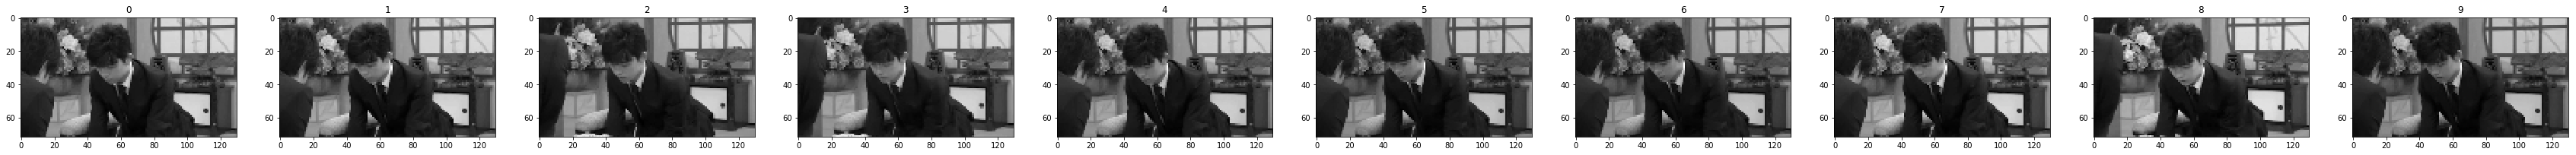

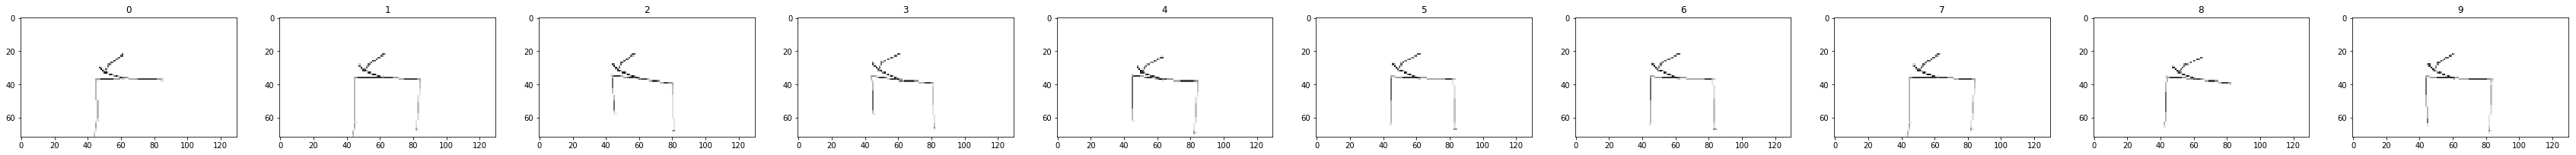

cluster id: 19, total: 66


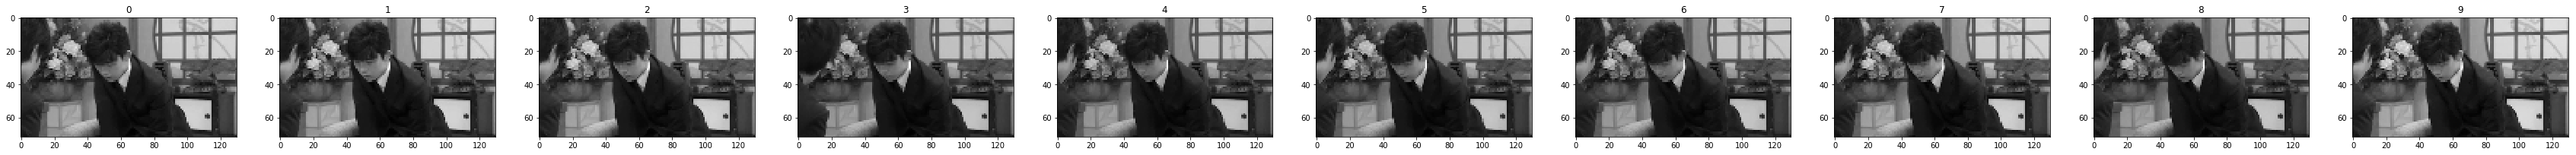

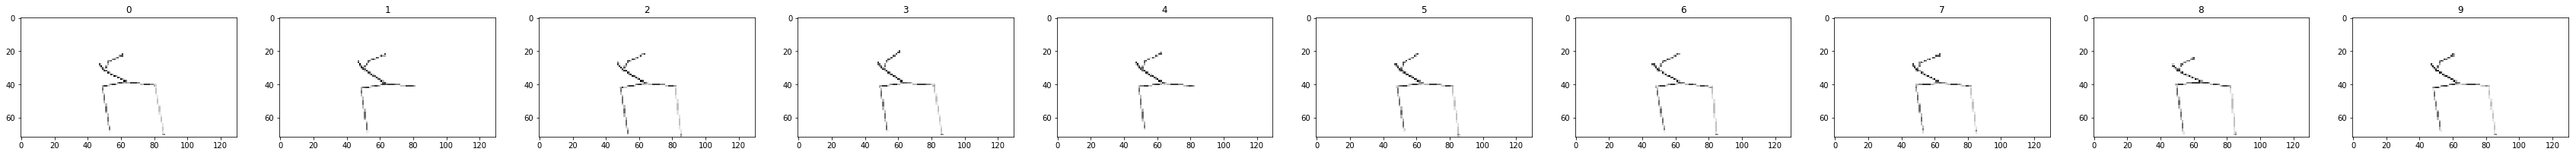

cluster id: 20, total: 121


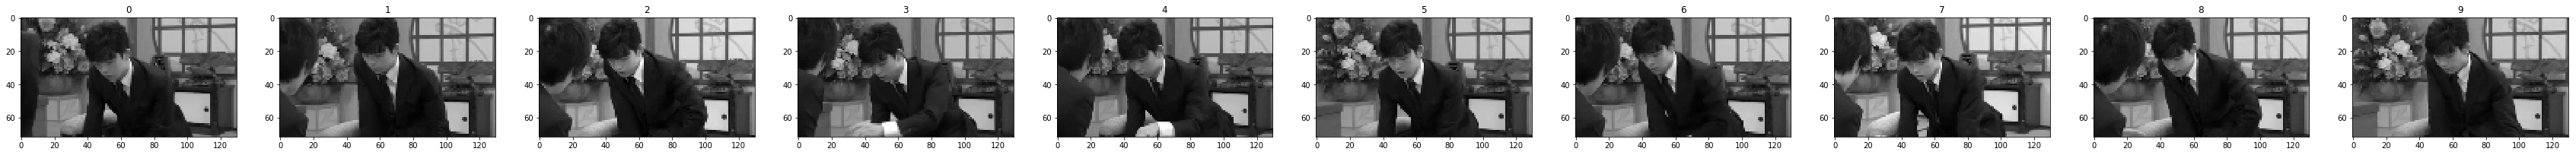

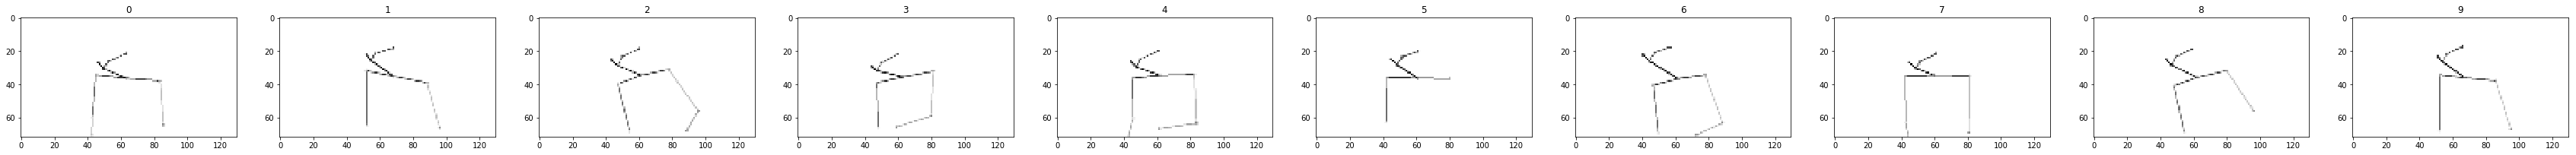

cluster id: 21, total: 47


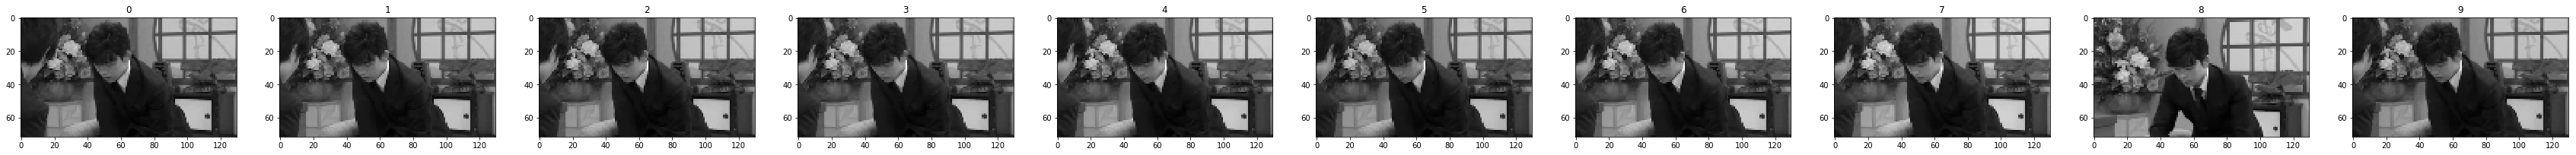

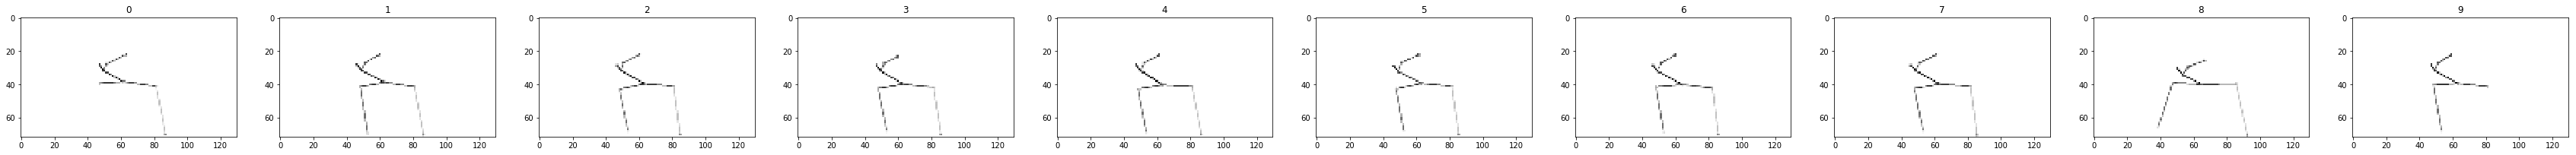

cluster id: 22, total: 40


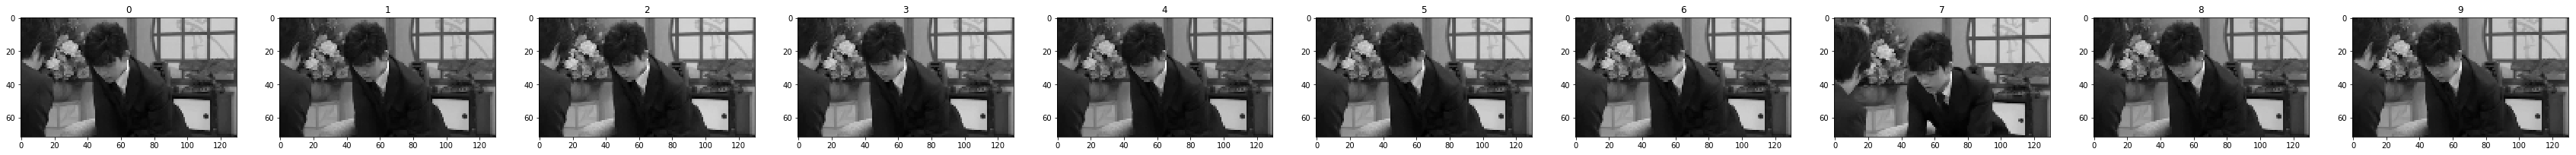

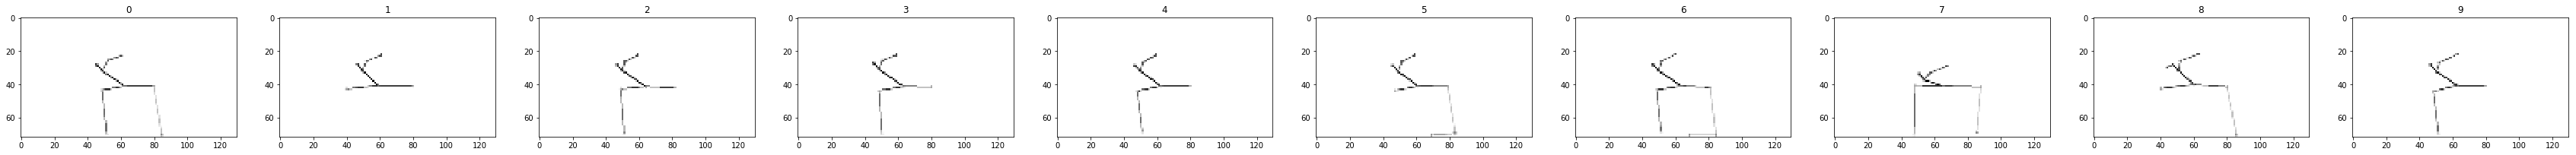

cluster id: 23, total: 21


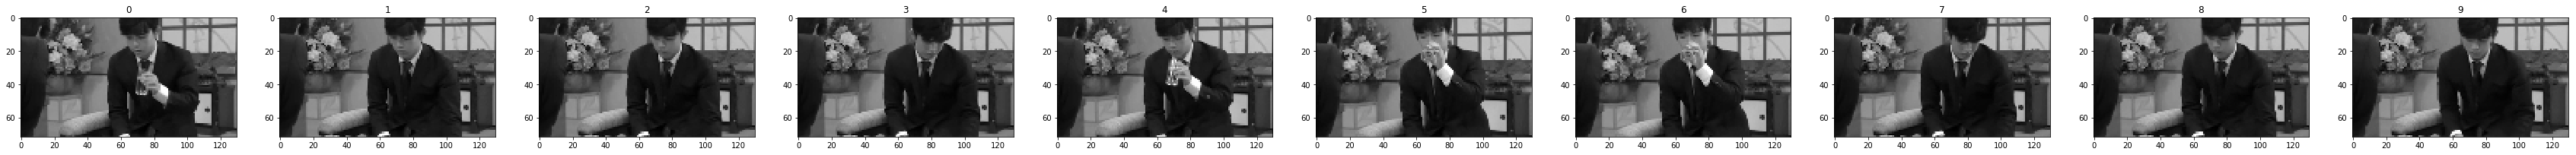

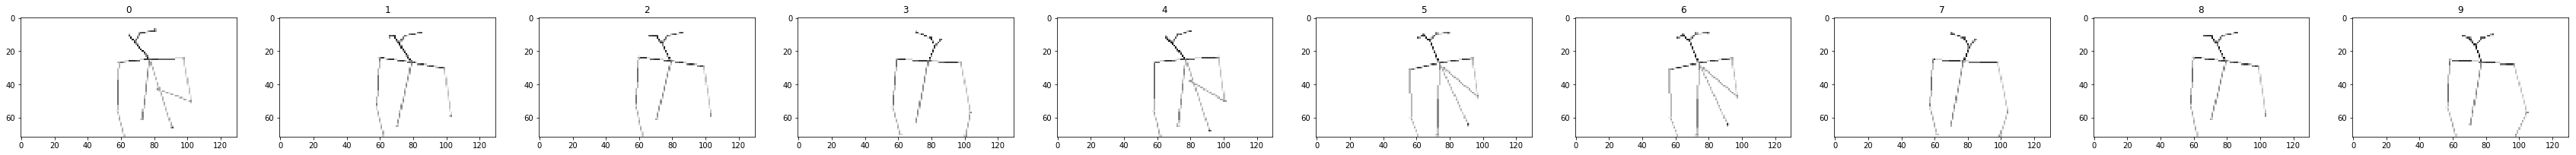

cluster id: 24, total: 16


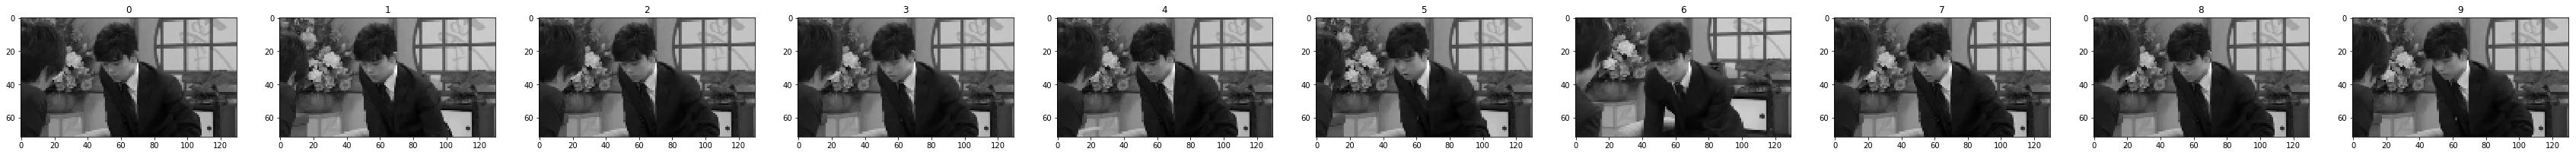

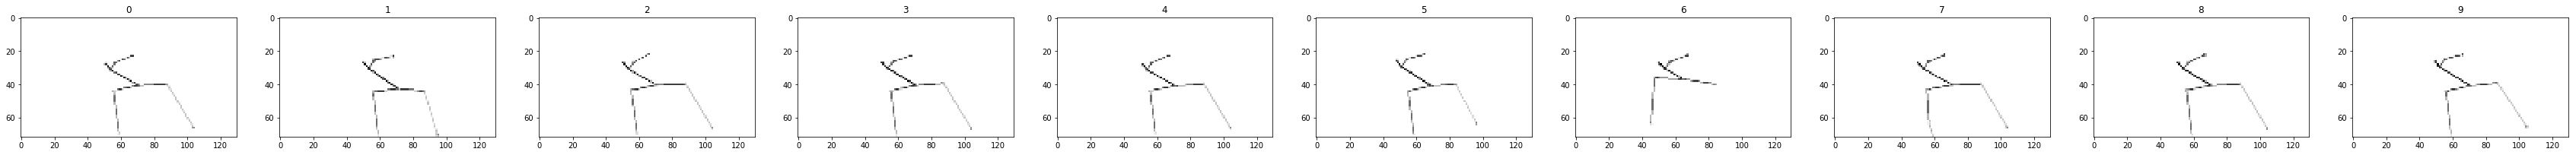

In [30]:
img_value = img_df["cluster_id"].value_counts()

for i in range(silhouette_max_id):
    cls_idx = img_df[img_df.cluster_id == i].index.values
    idx = np.random.choice(cls_idx, 10)
    print("cluster id: {}, total: {}".format(i, img_value[i]))
    compare_plot(np.array(orig_imgs)[idx], [_ for _ in range(10)], cmaps=["gray" for _ in range(10)])
    compare_plot(np.array(skel_imgs)[idx], [_ for _ in range(10)], cmaps=["gray" for _ in range(10)])

1回目のクラスタリングでは正しくスケルトンを取得できなかった画像が抽出された。

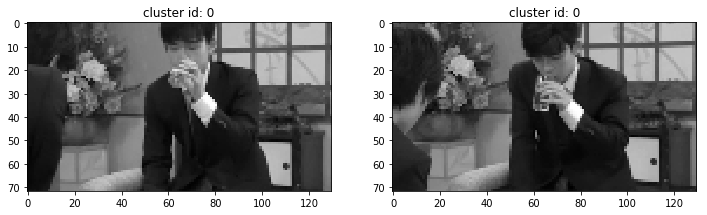

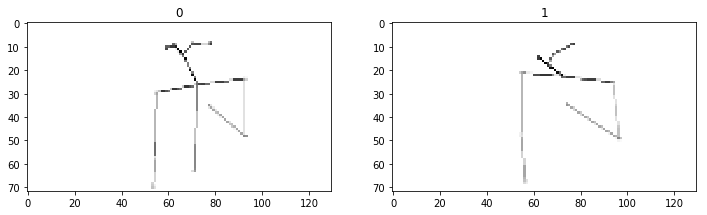

In [33]:
for i in [10]:
    cls_idx = img_df[img_df.cluster_id == i].index.values
    np.random.seed(4)
    idx = np.random.choice(cls_idx, 2)
    compare_plot(np.array(orig_imgs)[idx], ["cluster id: {}".format(_) for _ in [0, 0]], cmaps=["gray" for _ in range(2)])
    compare_plot(np.array(skel_imgs)[idx], [_ for _ in range(2)], cmaps=["gray" for _ in range(2)])